In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, Lambda, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetV2B0
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import random
import cv2
import pandas as pd



# Constants
BATCH_SIZE = 16
IMG_SIZE = (112, 112)
DATA_DIR = "/kaggle/input/11-785-fall-20-homework-2-part-2"
TEST_DIR = f"{DATA_DIR}/classification_data/test_data"
NUM_PAIRS_PER_PERSON = 1

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
print("Number of GPUs in strategy:", strategy.num_replicas_in_sync)

2025-07-29 08:34:52.106570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753778092.326642      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753778092.393644      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of GPUs in strategy: 2


I0000 00:00:1753778106.993360      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


# Preprocess data

## Verification Data Preprocessing

In [2]:


def load_and_preprocess_image(image_path, img_size=IMG_SIZE):
    if isinstance(image_path, str):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image: {image_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image_path
    image = cv2.resize(image, img_size)
    image = image.astype(np.float32)
    image = np.clip(image, 0, 255)
    return image


def create_pairs_from_classification_data(classification_dir=TEST_DIR, num_pairs_per_person=NUM_PAIRS_PER_PERSON):
    pairs = []
    person_dirs = [d for d in os.listdir(classification_dir) 
                  if os.path.isdir(os.path.join(classification_dir, d))]
    
    # Positive pairs
    for person_dir in person_dirs:
        person_path = os.path.join(classification_dir, person_dir)
        images = [f for f in os.listdir(person_path) 
                 if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if len(images) >= 2:
            for _ in range(num_pairs_per_person):
                img1, img2 = random.sample(images, 2)
                img1_path = os.path.join(person_path, img1)
                img2_path = os.path.join(person_path, img2)
                pairs.append((img1_path, img2_path, 1))
    
    # Negative pairs
    num_negative_pairs = len(pairs)
    for _ in range(num_negative_pairs):
        person1, person2 = random.sample(person_dirs, 2)
        person1_path = os.path.join(classification_dir, person1)
        person2_path = os.path.join(classification_dir, person2)
        images1 = [f for f in os.listdir(person1_path) 
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        images2 = [f for f in os.listdir(person2_path) 
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if images1 and images2:
            img1 = random.choice(images1)
            img2 = random.choice(images2)
            img1_path = os.path.join(person1_path, img1)
            img2_path = os.path.join(person2_path, img2)
            pairs.append((img1_path, img2_path, 0))
    
    random.shuffle(pairs)
    return pairs


def prepare_dataset_numpy(pairs, img_size=IMG_SIZE):
    images1, images2, labels = [], [], []
    for img1_path, img2_path, label in pairs:
        try:
            img1 = load_and_preprocess_image(img1_path, img_size)
            img2 = load_and_preprocess_image(img2_path, img_size)
            images1.append(img1)
            images2.append(img2)
            labels.append(label)
        except Exception as e:
            print(f"Error loading pair {img1_path}, {img2_path}: {e}")
            continue
    return np.array(images1), np.array(images2), np.array(labels)

In [3]:

test_pairs = create_pairs_from_classification_data()
test_images1, test_images2, test_labels = prepare_dataset_numpy(test_pairs)
print(f"Number of test pairs generated: {len(test_pairs)}")



Number of test pairs generated: 8000


## Classification data Preprocessing

In [4]:
# Create data generator for test data
def create_test_generator():
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        shuffle=False
    )
    return test_generator

In [5]:
test_generator = create_test_generator()
print(f"Number of test samples: {test_generator.samples}")

Found 8000 images belonging to 4000 classes.
Number of test samples: 8000


# Evaluate Classification Model

In [14]:
def evaluate_model_classification(model_path, test_generator):
    model = load_model(model_path, safe_mode=False)

    
    # Predict
    with strategy.scope():
        predictions = model.predict(test_generator, batch_size=BATCH_SIZE)
    true_labels = test_generator.classes
    
    # Compute metrics
    predicted_labels = np.argmax(predictions, axis=1)
    test_accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Micro-average ROC
    y_true_bin = np.eye(len(test_generator.class_indices))[true_labels]
    y_score = predictions
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    print("\nClassification Model Metrics:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Micro-average AUC: {roc_auc:.4f}")
    
    # Compute MAE and MSE
    test_mae = mean_absolute_error(y_true_bin, predictions)
    test_mse = mean_squared_error(y_true_bin, predictions)

    # Print metrics
    print("\nClassification Model Metrics:")
    print(f"Mean Absolute Error (MAE): {test_mae:.4f}")
    print(f"Mean Squared Error (MSE): {test_mse:.4f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Model': ['classification_model'],
        'Accuracy': [test_accuracy],
        'MAE': [test_mae],
        'MSE': [test_mse],
        'AUC': [roc_auc]
    })
    metrics_df.to_csv('classification_metrics.csv', index=False)
    print("Metrics saved to 'classification_metrics.csv'")

    # Save predictions to CSV with image paths
    image_paths = test_generator.filenames
    predictions_df = pd.DataFrame({
        'Image_Path': image_paths,
        'Actual_Label': true_labels,
        'Predicted_Label': predicted_labels
    })
    predictions_df.to_csv('classification_predictions.csv', index=False)
    print("Predictions saved to 'classification_predictions.csv'")

    return {
        'accuracy': test_accuracy,
        'mae': test_mae,
        'mse': test_mse,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    } 

In [15]:
test_generator = create_test_generator()
print(f"Number of test samples: {test_generator.samples}")

# Path to classification model
classification_model_path = "/kaggle/input/siamese_model/keras/default/5/classification_model.keras"

# Evaluate classification model
classification_metrics = evaluate_model_classification(classification_model_path, test_generator)

Found 8000 images belonging to 4000 classes.
Number of test samples: 8000


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step

Classification Model Metrics:
Test Accuracy: 0.7544
Micro-average AUC: 0.9986

Classification Model Metrics:
Mean Absolute Error (MAE): 0.0001
Mean Squared Error (MSE): 0.0001
Metrics saved to 'classification_metrics.csv'
Predictions saved to 'classification_predictions.csv'


# Evaluate Siamese Network Model

## Siamese model using Concat layer

In [22]:
def evaluate_common(model, test_images1, test_images2, test_labels, test_pairs, batch_size=BATCH_SIZE):
    
    with strategy.scope():
        predictions = model.predict([test_images1, test_images2], batch_size=batch_size)
    predictions = predictions.flatten()
    
    
    binary_predictions = (predictions > 0.5).astype(np.int32)
    test_accuracy = accuracy_score(test_labels, binary_predictions)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    fpr, tpr, _ = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)

    # Save predictions to CSV with image paths
    predictions_df = pd.DataFrame({
        'Image1_Path': [pair[0] for pair in test_pairs],
        'Image2_Path': [pair[1] for pair in test_pairs],
        'Actual_Label': test_labels,
        'Predicted_Label': binary_predictions,
        'Similarity_Score': predictions
    })
    predictions_df.to_csv('predictions_common.csv', index=False)
    
    return {
        'accuracy': test_accuracy,
        'mae': mae,
        'mse': mse,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'predictions': predictions,
        'binary_predictions': binary_predictions
    }

In [24]:

def evaluate_model_concat(model_path, test_images1, test_images2, test_labels, test_pairs):
   
    model = load_model(model_path, safe_mode=False)  # Không cần custom_objects
    
   
    print("\nConcatenate Model Summary:")
    model.summary()

    metrics = evaluate_common(model, test_images1, test_images2, test_labels, test_pairs)
    
   
    print("\nConcatenate Model Metrics:")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f}")
    print(f"Mean Squared Error (MSE): {metrics['mse']:.4f}")
    print(f"Area Under ROC Curve (AUC): {metrics['roc_auc']:.4f}")
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Model': ['concatenate_model'],
        'Accuracy': [metrics['accuracy']],
        'MAE': [metrics['mae']],
        'MSE': [metrics['mse']],
        'AUC': [metrics['roc_auc']]
    })
    metrics_df.to_csv('concatenate_metrics.csv', index=False)
    
    # Save predictions to CSV with image paths
    predictions_df = pd.DataFrame({
        'Image1_Path': [pair[0] for pair in test_pairs],
        'Image2_Path': [pair[1] for pair in test_pairs],
        'Actual_Label': test_labels,
        'Predicted_Label': metrics['binary_predictions'],
        'Similarity_Score': metrics['predictions']
    })
    predictions_df.to_csv('concatenate_predictions.csv', index=False)
    
    return {
        'accuracy': metrics['accuracy'],
        'mae': metrics['mae'],
        'mse': metrics['mse'],
        'roc_auc': metrics['roc_auc'],
        'fpr': metrics['fpr'],
        'tpr': metrics['tpr']
    }

In [25]:
concat_model_path = "/kaggle/input/siamese_model/keras/default/5/cosine_metrics_model.keras"
concat_metrics = evaluate_model_concat(concat_model_path, test_images1, test_images2, test_labels,test_pairs)


Concatenate Model Summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 512)       │  6,577,232 │ image1[0][0],     │
│ (Functional)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ functional_6[0][… │
│ (Concatenate)       │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    524,800 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        513 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,184,373 (80.81 MB)

 Trainable params: 7,040,913 (26.86 MB)

 Non-trainable params: 61,632 (240.75 KB)

 Optimizer params: 14,081,828 (53.72 MB)

500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step

Concatenate Model Metrics:
Test Accuracy: 0.8812
Mean Absolute Error (MAE): 0.1499
Mean Squared Error (MSE): 0.0884
Area Under ROC Curve (AUC): 0.9490


## Evaluate model using Cosine metrics

In [28]:


def cosine_similarity(vectors):
    import tensorflow.keras.backend as K
    x, y = vectors
    x = K.l2_normalize(x, axis=1)
    y = K.l2_normalize(y, axis=1)
    return K.sum(x * y, axis=1, keepdims=True)

def l2_normalize(x):
    import tensorflow.keras.backend as K

    return K.l2_normalize(x, axis=1)


def create_new_functional_1():
    input_shape = (112, 112, 3)
    inputs = Input(shape=input_shape, name='input_layer_2')
    efficientnet = EfficientNetV2B0(include_top=False, input_shape=input_shape, weights=None, name='efficientnetv2-b0')(inputs)
    x = GlobalAveragePooling2D(name='global_average_pooling2d')(efficientnet)
    x = Dense(512, name='embedding_dense1')(x)
    x = BatchNormalization(name='embedding_bn1')(x)
    x = Activation('relu', name='activation_bn1')(x)
    x = Dropout(0.5, name='embedding_dropout1')(x)
    x = Dense(128, name='final_embeddings')(x)
    x = Lambda(l2_normalize, name='l2_normalize')(x)
    return Model(inputs=inputs, outputs=x, name='functional_1')



def evaluate_model_cosine(model_path, test_images1, test_images2, test_labels, test_pairs):
  
    new_functional_1 = create_new_functional_1()
    

    model = load_model(
        model_path,
        custom_objects={
            'cosine_similarity': cosine_similarity,
            'l2_normalize': l2_normalize
        },
        safe_mode=False
    )
    
   
    functional_1 = model.get_layer('functional_7')
    new_functional_1.set_weights(functional_1.get_weights())

    
    image1 = Input(shape=(112, 112, 3), name='image1')
    image2 = Input(shape=(112, 112, 3), name='image2')
    embedding1 = new_functional_1(image1)
    embedding2 = new_functional_1(image2)
    similarity = Lambda(cosine_similarity, name='cosine_similarity')([embedding1, embedding2])
    x = Dense(64, activation='relu', name='similarity_dense1')(similarity)
    x = Dropout(0.5, name='similarity_dropout')(x)
    output = Dense(1, activation='sigmoid', name='binary_output')(x)
    new_model = Model(inputs=[image1, image2], outputs=output, name='functional_3')
    
   
    for layer in new_model.layers:
        if layer.name in ['similarity_dense1', 'similarity_dropout', 'binary_output']:
            layer.set_weights(model.get_layer(layer.name).get_weights())
    
   
    print("Cosine Model Summary:")
    new_model.summary()
    print("Functional_1 Summary:")
    new_functional_1.summary()
    
  
    metrics = evaluate_common(new_model, test_images1, test_images2, test_labels, test_pairs)
    
  
    print("\nCosine Model Metrics:")
    print(f"Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f}")
    print(f"Mean Squared Error (MSE): {metrics['mse']:.4f}")
    print(f"Area Under ROC Curve (AUC): {metrics['roc_auc']:.4f}")
    
    
    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Model': ['concatenate_model'],
        'Accuracy': [metrics['accuracy']],
        'MAE': [metrics['mae']],
        'MSE': [metrics['mse']],
        'AUC': [metrics['roc_auc']]
    })
    metrics_df.to_csv('concatenate_metrics.csv', index=False)
    
    # Save predictions to CSV with image paths
    predictions_df = pd.DataFrame({
        'Image1_Path': [pair[0] for pair in test_pairs],
        'Image2_Path': [pair[1] for pair in test_pairs],
        'Actual_Label': test_labels,
        'Predicted_Label': metrics['binary_predictions'],
        'Similarity_Score': metrics['predictions']
    })
    predictions_df.to_csv('concatenate_predictions.csv', index=False)
    
    return {
        'accuracy': metrics['accuracy'],
        'mae': metrics['mae'],
        'mse': metrics['mse'],
        'roc_auc': metrics['roc_auc'],
        'fpr': metrics['fpr'],
        'tpr': metrics['tpr']
    }




In [30]:

cosine_model_path = "/kaggle/input/siamese_model/keras/default/5/concat_siamese_model.keras"

cosine_metrics = evaluate_model_cosine(cosine_model_path, test_images1, test_images2, test_labels, test_pairs)

Cosine Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │  6,642,896 │ image1[0][0],     │
│ (Functional)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ functional_1[0][… │
│ (Lambda)            │                   │            │ functional_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_dense1   │ (None, 64)        │        128 │ cosine_similarit… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_dropout  │ (None, 64)        │          0 │ similarity_dense… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_output       │ (None, 1)         │         65 │ similarity_dropo… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,643,089 (25.34 MB)

 Trainable params: 6,581,457 (25.11 MB)

 Non-trainable params: 61,632 (240.75 KB)

Functional_1 Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dense1 (Dense)        │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_bn1                   │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_bn1 (Activation)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout1 (Dropout)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_embeddings (Dense)        │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalize (Lambda)           │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,642,896 (25.34 MB)

 Trainable params: 6,581,264 (25.11 MB)

 Non-trainable params: 61,632 (240.75 KB)

500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step

Cosine Model Metrics:
Test Accuracy: 0.8704
Mean Absolute Error (MAE): 0.1730
Mean Squared Error (MSE): 0.0949
Area Under ROC Curve (AUC): 0.9426


# Plot the ROC curves

In [31]:
# Plot ROC curves for all three models
def plot_roc_curves(metrics_list, labels, output_file='roc_curves_comparison.png'):
    plt.figure(figsize=(10, 8))
    colors = ['darkorange', 'blue', 'green']
    linestyles = ['-', '--', '-.']
    for metrics, label, color, linestyle in zip(metrics_list, labels, colors, linestyles):
        plt.plot(metrics['fpr'], metrics['tpr'], color=color, linestyle=linestyle, lw=2, 
                 label=f'{label} (AUC = {metrics["roc_auc"]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves Comparison', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

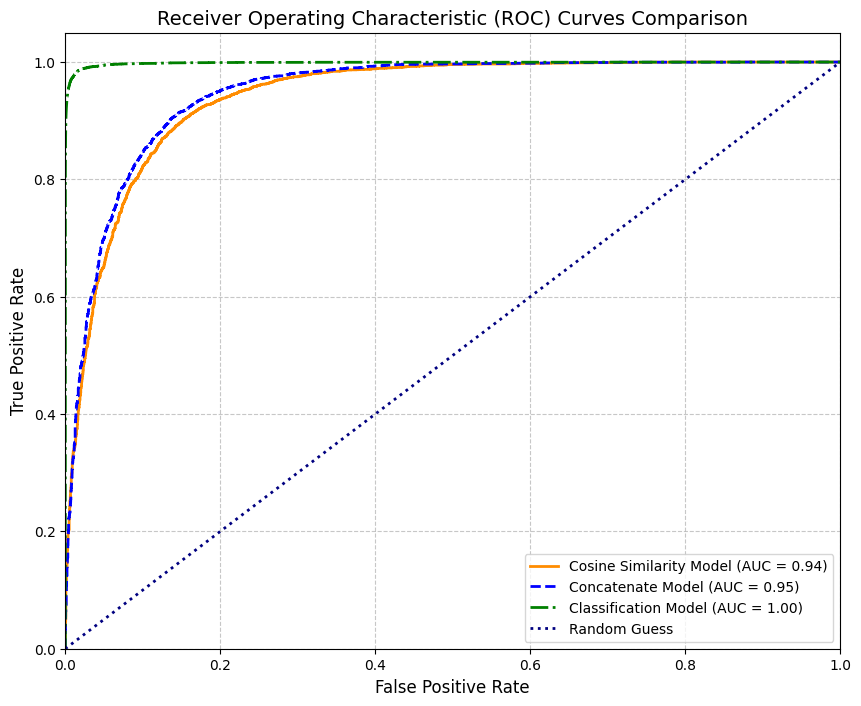

In [32]:

plot_roc_curves(
    metrics_list=[cosine_metrics, concat_metrics,classification_metrics],
    labels=['Cosine Similarity Model', 'Concatenate Model', 'Classification Model'],
    output_file='roc_curves_comparison.png'
)